# Детекция типов товара

## Постановка задачи

Необходимо создать модель, обрабатывающую фрагмент текста и определяющую, какой вид продукции в этом фрагменте содержится.

Датасет можно скачать по следующей [ссылке](https://axe.inline-ltd.ru/data/meatinfo.csv). В нём есть множество видов продукции, анализируем только те из них, для которых есть хотя бы 500 примеров.

## Краткое описание способа решения

Предобработка текста осуществлялась с помощью `лемматизации` и `очистки` от ненужных слов и символов (стоп-слова, пунктуация и тд)  
Токенизация с помощью библиотеки `youtokentome` по методу `Byte Pair Encoding`, мешка n-грамм. Библиотека написана на С++, поэтому для её работы нужно обязательно Miscrosoft Visual Studio Build Tools для Windows или gcc++ для Linux. Без этих инструментов библиотека работать `не будет`.  
Модель `BERT`-архитектуры, написанная с помощью собственных блоков. Для обучения используется `lightning` и `hydra` для менеджмента конфигов.  
Итоговая модель выгружена в формат `onnx`.  

Для использования модели в файле `tests/prod_functions.py` есть необходимая функция `get_result`, а в `tests/some_tests.py` есть пример по использованию.

## Краткие результаты

Была обучена совсем небольшая модель BERT-архитектуры (4.4 млн. параметров, 17.5 Мб), которая дала точность в 92% (примерно 7% точности утекли в определение классов "Кура" и "Цыплёнок", которые модель немного путает). 

## Импорты библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from sklearn.model_selection import train_test_split
import re

import youtokentome as yttm

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alagril/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных и их анализ

Для начала необходимо посмотреть, как выглядят данные, что они из себя представляют

In [1]:
# Относительный путь к данным для обработки в формате *.csv
filepath = "datasets/meatinfo.csv"

In [3]:
dt = pd.read_csv(filepath, sep=";", header=0)
dt.dropna(inplace=True)

In [19]:
n_start = 15
n_end = 25

print(dt["text"][n_start:n_end].to_numpy())
print()
print(dt["mtype"][n_start:n_end].to_numpy())

['Баранина, 12 частей, охл. цена 450 руб.'
 'Баранина, 12 частей, охл. цена 455 руб.'
 'Баранина, 12 частей, охл. цена 550 руб.'
 'Баранина   Продам Баранина  на складе\n\n 6 кусков вес до 20 кг - 344 бойня. Постная есть фото. - 160 руб\n\nОкорок бк - 275 руб'
 'Баранина (6 отрубов) ООО "МК Сибирский Крестьянин"  реализует мясо баранины на кости (6 отрубов) заморозка, цена 220 руб/кг.'
 'Баранина (разруб в 6 частях), Продам баранину в 6 частях.(Midfield). Сроки короткие.\nНа остатках 1500 кг.'
 'баранина (ягнята) замороженная 6 частей баранинна (ягнята) дагестанская, разделанные на 6 частей замороженные (шоковая заморозка) упакованная в гофротару, имеются все документы.\n доставка до Москвы бесплатно. цена 265-285 руб.'
 'баранина 6 отрубов'
 'Баранина 6 отрубов (зам.) РФ - 240,00 Продам баранину 6 отрубов, заморож., на кости, в анатомической пропорции в гофрокоробе 22-25кг, РФ. \nНа постоянной основе. Доставка. Цена 240,00 руб/кг. На объем предоставляется скидка.'
 'Баранина 6 отрубов

Итак, что мы можем видеть

- В текстах присутствует очень много сокращений
- Тексты могут достаточно сильно отличаться по размеру. Где-то это пара слов, а где-то это может быть несколько абзацев.
- В текстах присутствует много дополнительной и не нужной для понимания типа товара информации, вроде цен, веса, местами обильные знаки препинания, контакты для связи

Посмотрим на классы товаров, которые встречаются в нашей выборке

In [21]:
labels = dt.groupby("mtype")["text"].nunique()
labels

mtype
 Лопаточная часть (Chuck) буйвол                                                              1
(OFFAL EXP №4407 Аргентина)                                                                   1
125р.                                                                                         1
295,00 руб|кг                                                                                 1
Feb-20                                                                                        2
Mar-20                                                                                        1
OFFAL EXP №4407 Аргентина                                                                     1
Баранина                                                                                   1116
Бобер                                                                                         1
Буйволятина                                                                                  75
Глухарь                           

Как видно, если смотреть по уникальным значениям, тут очень много классов товаров, количество примеров которых не превышает и 10 (Бобёр, Коза, Медвежатина и др.). На таком количестве примеров, конечно, обучиться нельзя. Также здесь присутсвуют ошибки и выбросы ("Лопаточная часть (Chuck) буйвол" или "295,00 руб|кг"), которые также надо исключить из выборки для обучения.

Поэтому мы возьмём только те классы, количество примеров для которых начинается от 500 (по ТЗ).

In [22]:
labels = labels.loc[labels >= 500].index.tolist()
labels

['Баранина', 'Говядина', 'Индейка', 'Кура', 'Свинина', 'Цыпленок']

И у нас осталось только вот эти 6 классов:
- Баранина
- Говядина
- Индейка
- Кура
- Свинина
- Цыпленок

Также можно сразу отметить, что классы "Кура" и "Цыплёнок" могут быть схожи и модель может их путать

Составим словарик перевода этих классов в числовой вариант

In [36]:
label_to_num = dict()
for idx in range(len(labels)):
    label_to_num[labels[idx]] = idx

print(label_to_num)

{'Баранина': 0, 'Говядина': 1, 'Индейка': 2, 'Кура': 3, 'Свинина': 4, 'Цыпленок': 5}


Теперь оставим в нашем датасете только примеры для этих шести перечисленных выше классов товаров

In [23]:
dt = dt.loc[dt["mtype"].isin(labels)]

In [24]:
dt.groupby("mtype")["text"].nunique()

mtype
Баранина    1116
Говядина    8420
Индейка     1337
Кура        1570
Свинина     3049
Цыпленок     942
Name: text, dtype: int64

Построим график распределения примеров для каждого класса для наглядности

In [25]:
def plot_unique_labels(labels, plot_name = "Распределение уникальных значений"):
    """Функция для построение графика распределения классов в выборке"""
    unique_labels, count_unique_labels = np.unique(labels, return_counts=True)
    plt.barh(width = count_unique_labels, y=list(unique_labels))
    plt.title(plot_name)
    plt.show()

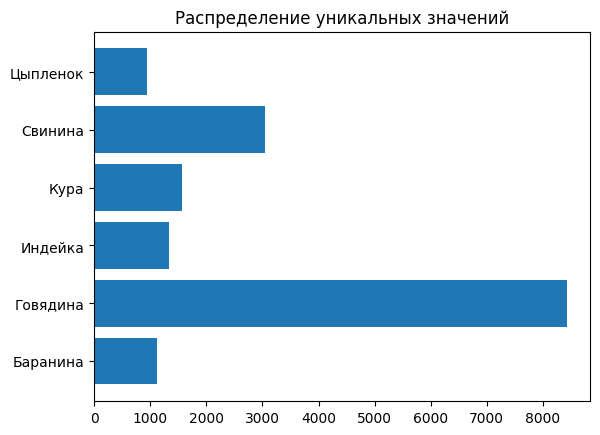

In [26]:
plot_unique_labels(dt["mtype"])

На графике видно, что распределение примеров не одинаково. Примеров для "Говядины", в сравнении с остальными, очень много, больше 8000, тогда как для "Цыплёнка" примеров не доходит и до 1000

## Предобработка данных

Поскольку у нас задача классификации текстов, задача сохранить для анализа исходный вариант отзыва у нас не стоит, нам важно передать только суть. Поэтому для сокращения словаря мы используем `лемматизацию` - приведение исходного слова в его начальную форму.

Также необходимо убрать "стоп-слова" - слова, которые часто встречаются в речи, но при этом несут очень мало смысловой нагрузки - и знаки пунктуации, которые в нашей задаче практически не несут смысла, при этом сокращая словарь

### Лемматизация и очистка данных

Лемматизацию проводим с помощью библиотеки `pymystem3`

In [30]:
mystem = Mystem()

Также из библиотеки `nltk` возьмём список стоп-слов

In [32]:
russian_stopswords = stopwords.words("russian")
np.array(russian_stopswords)

array(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как',
       'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у',
       'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот',
       'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда',
       'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть',
       'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь',
       'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут',
       'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем',
       'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже',
       'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того',
       'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом',
       'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были',
       'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец',
       'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
 

И знаки пунктуации из встроенного модуля `string`

In [33]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
def text_lemmatize(text):
    """Функция для лемматизации текста с помощью библиотеки pymystem3"""
    mystem = Mystem()
    russian_stopswords = stopwords.words("russian")
    
    lemma_texts = [mystem.lemmatize(phrase) for phrase in text]
    answer = []
    for phrase in lemma_texts:
        temp_phrase = [token for token in phrase if token not in russian_stopswords and token != " " and token.strip() not in punctuation]
        answer.append(temp_phrase)
    return answer

In [38]:
# Лемматизация текста
lemma_texts = text_lemmatize(dt["text"])

In [39]:
# Перевод классовых меток из текста в числа
num_labels = [label_to_num[label] for label in dt["mtype"]]

Посмотрим на то, как выглядит текст отзыва после лемматизации и удалении стоп-слов и знаков пунктуации

In [41]:
for i in range(5):
    print(dt["text"][i], " -- ", dt["mtype"][i])
print("-----")
for i in range(5):
    print(lemma_texts[i], " -- ", num_labels[i])

12 частей баранина  12 частей баранина  --  Баранина
Баранина, 12 частей, зам. цена 260 руб.  --  Баранина
Баранина, 12 частей, зам. цена 315 руб.  --  Баранина
Баранина, 12 частей, охл.  --  Баранина
Баранина, 12 частей, охл. цена 220 руб.  --  Баранина
-----
['12', 'часть', 'баранина', '12', 'часть', 'баранина']  --  0
['баранина', '12', 'часть', 'зам', 'цена', '260', 'руб']  --  0
['баранина', '12', 'часть', 'зам', 'цена', '315', 'руб']  --  0
['баранина', '12', 'часть', 'охла']  --  0
['баранина', '12', 'часть', 'охла', 'цена', '220', 'руб']  --  0


Видим, что лемматизация сравнительно неплохо справилась с сокращениями - по крайней мере, она не сломалась. Хотя в текстах всё ещё присутствуют цифры, которые не играют никакой роли в определении класса товара

Для очистки текстов от различных мелочей, которые лучше не обрабатывать перед построением словаря, можно воспользоваться регулярным выражением `[а-яА-Я ]+`. В этом случае в тексте отзывов останутся только буквы и пробелы

In [48]:
def for_txt_file(texts, filename):
    """Фунция оставляет в тексте только символы букв и пробелы с помощью регулярного выражения, 
    а также записыват текст в файл .txt формата для дальнейшей обработки токенизатором"""
    file = open(filename, "w")
    for phrase in texts:
        phr = " ".join(phrase)
        phr = re.findall("[а-яА-Я ]+", phr)
        phr = " ".join(phr) + "\n"
        file.write(phr)
    file.close()

In [49]:
# Путь до нового файла в формате .txt для записи предобработанного текста
filename_lemma = "datasets/lem_text.txt"

In [50]:
for_txt_file(lemma_texts, filename_lemma)

Посмотрим, все ли тексты перекодировались правильны и не исчезли ли какие-то объявления

In [52]:
print(len(dt["text"]))
print(len(lemma_texts))

16438
16438


Что после лемматизации, что после очистки регулярными выражениями количество объявлений о продаже мяса осталось равным 16438. Значит, ничего из них не потерялось, и мы можем их в дальнейшем подгружать из уже предобработанного txt-файла

### Построение словаря с помощью Byte-Pair Encoding

Поскольку у нас задача на специфичную область, словарь токенов нам нужен специфичный и отражающий нашу область и проблематику. Поэтому словарь будем строить с помощью мешка n-грамм, реализованного через BPE библиотеки `youtokentome`. Таким образом для наших конкретных текстов построиться словарь, который будет отражать конкретную специфичную выборку.  
Однако надо подобрать размер словаря, который будет лучше всего аппроксимировать самые частые n-граммы

In [59]:
filename_lemma = "datasets/lem_text.txt"
VOCAB_SIZE = 300
BPE_MODEL_FILENAME = f"weights/bpe_{VOCAB_SIZE}.yttm"
#-----
# yttm.BPE.train(data=filename_lemma, vocab_size=VOCAB_SIZE, model=BPE_MODEL_FILENAME)
#-----
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(" ".join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а н р и т к е с в д л й г у п б м ь я ы з ж ц ч ш ф х щ ю ъ э Р Б К С П М Т З Д Ф Ч О В А Н Л Х Г Ш Ц У Ж И Е Я Ы Ъ Й на ▁к ов ▁п ▁г ▁с ть ка ▁р ый ро ▁о ный ст ▁гов ина уб ать ▁говя ин ий ▁м ор ен ▁з ▁б ▁ц ▁т во ▁руб ▁за ла дина ▁говядина ой ▁це ол ▁в ок ра ▁цена ре ост ▁про ▁д ▁св ия ▁зам ав ос ▁кг ат ▁свин ри ел оро ▁н он ер жи ие ▁мя ес ли ло ▁ку жий ▁на ▁мяс ▁свиной ▁об ▁говяжий ▁прод ▁ф ет уш кий вать ру од ей ар от ред ить ▁мясо ство ан ▁ин остав из орт ак вод ▁у ит ль ▁пол ▁жи ▁инд ег ент ас чный ▁произ ▁гост ▁производ ▁вы ейка ▁кури ▁пред ▁от оставка хла ень ова ▁вес ▁охла ▁ко ▁кат ▁ш ара ▁индейка ед ут ель авать ский ▁пе ог ва ▁гол ук ▁продавать ся ▁ка ем об ость жд мент коро ▁доставка ▁ск воз руд ▁туш ория ▁ло ▁куриный ция ▁тон ▁ч ▁катег енный овы ▁категория ▁оп лад ▁нали че ний ▁жир ▁х ни ▁бара пат ной ▁ра рез ств ля ле ▁кор ▁склад ▁полут ▁са ▁налич ▁полутуш ▁замор живать оку ▁груд ▁цб аживать ▁замораживать ▁наличие лаг ▁тонна ▁производство ▁лопа

В словаре, помимо токенов, встречающихся в тексте, существуют ещё 4 служебных токена:
- `<PAD>` токен паддинга, нулевой токен. Необходим для паддинга, чтобы модель понимала, что этот токен ничего не значит
- `<UNK>` токен для неизвестного словарю символа, если вдруг такой в тексте попадётся
- `<BOS>` токен начала строки (отзыва)
- `<EOS>` токен конца строки (отзыва)

Были рассмотрены словари разных размеров (200, 300, 400, 500, 800 слов). При рассмотрении (и обучении различных моделей) оптимальным смотрится словарь из 300 символов (так как при расширении какого-то заметного прироста это не даёт, а при уменьшении качество модели уже падает)

In [60]:
def load_text_from_file(filename):
    """Функция для загрузки из txt-файла текста"""
    with open(filename) as f:
        lines = [line[:-1] for line in f.readlines()]
    return lines

In [61]:
lemma_text = load_text_from_file(filename_lemma)

Посмотрим, что все тексты на месте, их количество - 16438 - не изменилось, и тексты соответсвуют классовым токенам

In [62]:
print(len(lemma_text))
print(lemma_text[:5])
print(len(num_labels))
print(num_labels[:5])

16438
[' часть баранина   часть баранина', 'баранина   часть зам цена   руб', 'баранина   часть зам цена   руб', 'баранина   часть охла', 'баранина   часть охла цена   руб']
16438
[0, 0, 0, 0, 0]


Поделим выборку на тренировочную и тестовую (валидационную, потому что по ней мы подбираем гиперпараметры). Возьмём 20% для валидационной части с помощью функции train_test_split из библиотеки scikit-learn

In [65]:
train_text, val_text, train_labels, val_labels = train_test_split(lemma_text, num_labels, test_size=0.1)

print(len(train_text))
print(len(val_text))

14794
1644


Поскольку выборка в тренировочную и тестовую часть происходит случайно, посмотрим, не изменилось ли у нас распределение (какой-то класс, например, практически вообще не попал в какую-то из выборок)

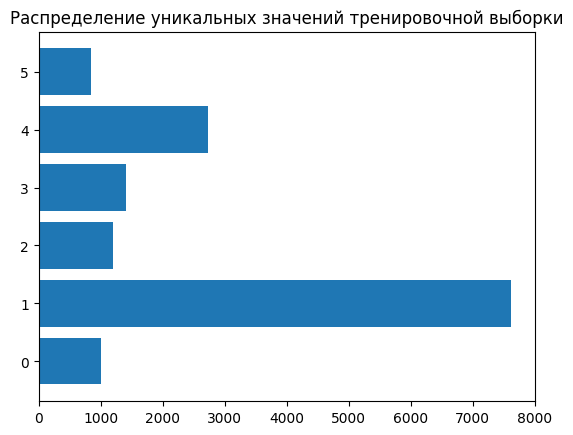

In [66]:
plot_unique_labels(train_labels, plot_name="Распределение уникальных значений тренировочной выборки")

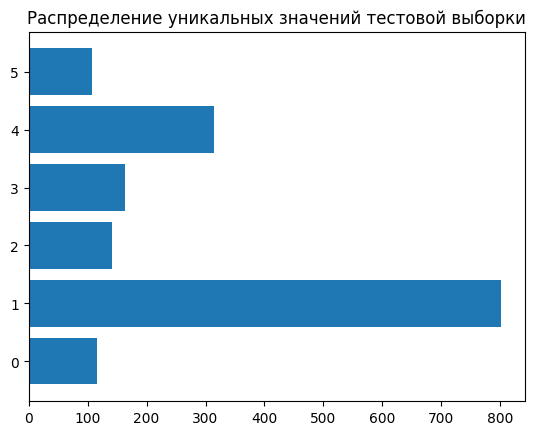

In [67]:
plot_unique_labels(val_labels, plot_name="Распределение уникальных значений тестовой выборки")

Как видно из графиков, распределение осталось такое же у всех

Теперь совершим токенизацию текста!

In [68]:
train_tokens = tokenizer.encode(train_text, bos=True, eos=True)
val_tokens = tokenizer.encode(val_text, bos=True, eos=True)

Осталось определить ещё одну вещь - длину исследуемого текста, которую будет обрабатывать модель, которая у всех должна быть одинаковой. Тексты и до этого были распределены в достаточно большом диапазоне возможных длин, а после токенизации, когда замена буквенных символов в токены не одинакова по размеру, амплитуда длин может быть ещё больше

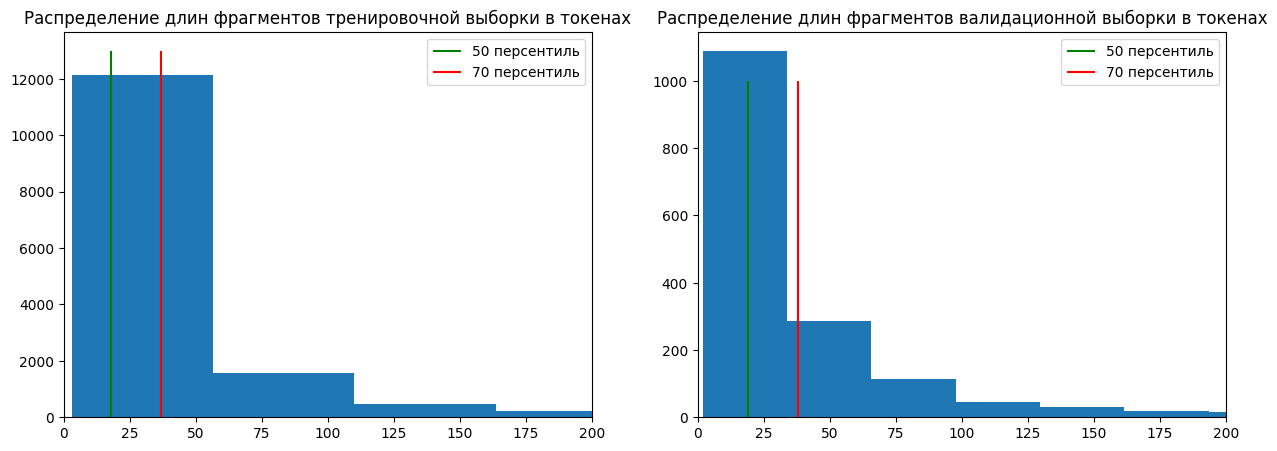

In [106]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

# Тренировочная выборка
axs[0].hist([len(sentence) for sentence in train_tokens], bins=100)
axs[0].vlines([np.percentile([len(sentence) for sentence in train_tokens], 50)], [0], [13000], label="50 персентиль", color="green")
axs[0].vlines([np.percentile([len(sentence) for sentence in train_tokens], 70)], [0], [13000], label="70 персентиль", color="red")
axs[0].set_title('Распределение длин фрагментов тренировочной выборки в токенах')
axs[0].legend()

# Тестовая выборка
axs[1].hist([len(sentence) for sentence in val_tokens], bins=100)
axs[1].vlines([np.percentile([len(sentence) for sentence in val_tokens], 50)], [0], [1000], label="50 персентиль", color="green")
axs[1].vlines([np.percentile([len(sentence) for sentence in val_tokens], 70)], [0], [1000], label="70 персентиль", color="red")
axs[1].set_title('Распределение длин фрагментов валидационной выборки в токенах')
axs[1].legend()

# Также обрежем x до 200 токенов, т.к. есть примеры с гигантскими значениями, которых очень мало
axs[0].set_xlim(0, 200)
axs[1].set_xlim(0, 200)

plt.show()

Длины текста в токенах могут быть совершенно разными, однако для словаря из 300 токенов больше 50% отзывов меньше 25 токенов. 70-персентиль находится примерно на 40 токенах.  
Таким образом, мы эверистически будем дополнять текст объявления до `40` токенов паддингом, а отзывы, что больше по длине - обрезать. Предполагаем, что основная информация находится в начале объёявления (если просмотреть датасет, можно заметить, что зачастую первым же словом пишут, что продают. Возможно, это связано с тем, что объявлений много, и на сайтах пишется начало, а продолжение скрыто за троеточием, которое надо раскрыть или вообще перейти на старницу объявление. Поэтому люди пишут самое важное в самом начале, чтобы это просто было видно при беглом просмотре кучи объявлений о продаже мяса).

Также в модели есть настройка, позволяющая менять длину входящего текста, так что можно посмотреть, насколько мы с этим параметром угадали

P.S. Дополнение

Как показала практика, при обрезке не до 40, а до `60` токенов модель работает примерно также, но чуть лучше отличает Куру от Цыплёнка

А вот увеличение до `80` ничего не изменило

## Построение модели

Для обучения модели построим несколько, не считая файлов конфига, питоновских файлов, которые находятся в пакете `product_detection`.
- `models` - папка, в которой находятся файлы модели и оболочка:
    - `model.py` для классов модели
    - `shell.py` для оболочки pytorch lightning
- `data.py` для логики обработки данных и классов Dataset и LightningDataModule
- `train.py` для тренировки модели

### data.py

Тут находятся функции, которые были рассмотрены выше в области `Предобработка данных`.  

Также здесь класс `LanduageModelDataset`, который наследуется от торчевского `Dataset`. Он принимает в себя уже лемматизированные и очищенные данные (те, что храняться в сохранённом txt-файле), а также размер chunk - длины объявления, которую будет модель обрабатывать. Он осуществляет возврат очищенных и обрезанных (или дополненных паддингом) данных и класс  

`TextClassification_DataModule` класса `LightningDataModule` осуществляет предобработку данных, описанных выше, от получения csv-файла до сохранения лемматизированных и очищенных файлов в txt-формат. Также кидает данные в `LanduageModelDataset` и при тренировке возвращает модули `DataLoader`.  

### model.py

Здесь находятся классы, по которым строится модель

Для построения модели с архитектурой энкодера трансформера с отдельным токеном класса используются следующие классы, написанные вручную:
1) `Class_Positions_Embeddings` - класс для создания позиционного кодирования и добавления токена класса, который модель в итоге и должна предсказать. Позиционное кодирование в данном случае реализуется через nn.Parameter, которые изменяются в ходе обучения модели, но можно использовать и статический вариант, вроде кодирования с помощью синусов и косинусов.
2) `MLP` - класс перцептрона для блока и для финальной классификации токена класса. Реализован через один входной и один выходной слой с возможностью повышения/понижения размерности.
3) `Attention` - класс внимания модели. Собственно, реализация классического внимания трансформера. Для увеличения продуктивности (повышения именно матричных операций для видеокарты) считается одна большая матрица, которая потом с помощью библиотеки einops делится на внимания голов.
4) `Block` - собственно, слой внимания вместе с нормализацией и перцептроном в конце. Есть настройка, в каком порядке использовать нормализацию - postnorm, то есть attention->skip_connection->norm->mlp_>skip_connection->norm, или prenorm, то есть norm->attention->skip_connection->norm->mlp_>skip_connection.
5) `Transformer` - класс трансформера. Просто несколько слоёв класса Block подряд.
6) `SpecificBERT` - класс, который собирает Class_Positions_Embeddings, Transformer и последний классификатор MLP вместе.

### shell.py

Здесь находятся класс оболочки модели в pytorch lightning и класс дополнительного логирования матрицы ответов

1) `Model_Lightning_Shell` - обёрнутый в lighning SpecificBERT. Используется два варианта sheduler - ReduceOnPlateau и OneCycleLR - и кросс-энтропия в качестве loss-функции.
2) `ConfMatrixLogging`, наследуемый от lightning.Callback. Он позволяет логировать на каждой эпохе обучения матрицу ответов модели по всем классам, что позволит детально посмотреть, что именно она не так предсказала.

### train.py

При запуске этого файла начинается обучение модели с заданными в конфиге параметрами. Управление конфигурационными файлами осуществляется с помощью `hydra`. 

Производится последовательное создание экземпляров класса `TextClassification_DataModule` и `Model_Lightning_Shell`, а также различных callback для lightning: 
- `WandbLogger` для логирования процесса обучения модели на wandb
- `ModelCheckpoint` для сохранения лучших весов модели по метрике `val_loss`
- `LearningRateMonitor` для просмотра, как изменялся lr во время обучения с помощью scheduler
- `EarlyStopping` для завершения обучения в случае, если модель начала переобучаться
- `ConfMatrixLogging`, определённый в shell.py

## Обучение модели

In [107]:
# Обучение можно запустить через следующую команду. 
# Гиперпарметры берутся из файла product_detection/conf/config.yaml
# Для работы и автоматического логирование на wandb необходим файл .env в корне с прописанным в нём WANDB_KEY

# Для использования scheduler ReduceOnPlateau:
# !python product_detection/train.py +scheduler=reduce_plateau

# Для использования scheduler OneCycleLR:
# !python product_detection/train.py +scheduler=one_cycle

При обучении мы смотрим на 3 метрики:
- Функция потерь - для понимания, что модель учится и приближается к минимуму
- F1-метрика - точность модели с учётом того, что количество примеров для каждого класса у нас сильно отличается
- Accuracy - точность модели без учёта разнокалиберности примеров

Прогон обучения модели осуществлялся с логированием результатов на [wandb](https://wandb.ai/lost_in_thoughts/product_detection)

## Анализ результатов обучения

Посмотрим, как обучилась наша модель. Для начала, распишем параметры модели:

| Параметр | Значение |
| --- | --- |
| Размер словаря | 300 |
| Окно контекста | 60 |
| Слои | 8 |
| Головы self-attention| 4 |
| Пространство эмбеддингов | 256 |
| Размерность mlp-классификатора | 512 |
| Dropout | 0.1 |
| Learning rate | 3e-4 |

И посмотрим на обучающие кривые, на точность модели:

![alt text](images/Training_curves.png)

Как видно, модель достаточно быстро вышла на "плато", получив неплохую точность в 0.92 как по f1, так и по accuracy. 

Посмотрим на матрицу ответов модели, чтобы понять, а где же она потеряла эти 8% точности:

![alt text](images/Answer_Matrix.png)

По матрице ответов видно, что модель может путать классы "Кура" и "Цыплёнок". Что неудивительно, ведь эти объявления по этим классам действительно смежные и оба относятся к куриным изделиям.

Остальные классы модель превосходно отличает и классфицирует за редкими исключениями-выбросами (не превышающими 1.5%), которые могут быть из-за:
- ошибки модели;
- кривого описания, где не написано, что продаётся, а просто, например, мясо и колв-о тонн, мол, покупатель же видит, что он смотрит в отделе "говядина";
- изначально неправильно классифицированного объект, человек ошибся, не туда нажал.

## Сохранение модели и её дальнейшее использование

Выберем модель с окном контекста в 60 в качестве той, которую будем использовать для финальных результатов. Сохраним её в формат `onnx` (конвертация сделана в файле product_detection/model_conversion.py, сами веса модели лежат по пути weights/self_model.onnx).

Поскольку для модели в формале onnx необходим пример входных данных (в том числе батч), а размер проверочного датасета я не знаю, будет ли он делаиться нацело на на какое-либо число, я сделал входную размерность модели (1, 60) и подаю на вход по одному примеру, после чего добавляю в лист ответа. При известной (фиксированной) размерности входных данных можно будет более оптимизированно представить эту функцию

Для дальнейшего использования используем функцию `get_result`. Ниже приведён пример загрузки проверочных данных (файл построенный по такому же принципу, как и исходный датасет - csv файл, с шапкой text;mtype, разделитем в виде точки с запятой).

In [5]:
from tests.prod_functions import get_result
from product_detection.data import load_dataset

def get_result_test():
    x, y = load_dataset("datasets/testmeat.csv", min_count=1)
    to_pred = pd.Series(x)

    answer = get_result(to_pred)

    for i in range(len(answer)):
        print(to_pred[i])
        print(answer[i])
        print("-----")

In [6]:
get_result_test()

Набор для бульона свиной Набор для бульона свиной  в наличии  76р/кг.
Свинина
-----
Мясо премиум Предлагаем котлетное мясо мраморной говядины.
Говядина
-----
спинка цб
Цыпленок
-----
Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20)
Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.
Говядина
-----
Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:
Кура
-----
Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.
Говядина
-----
